<b>Data Source: Coin Gecko </b><br>
<b>Code Source: Time Series Analysis in Python, 365 Careers</b>

# Import Library

In [91]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA  
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
sns.set()

# Data Preprocess

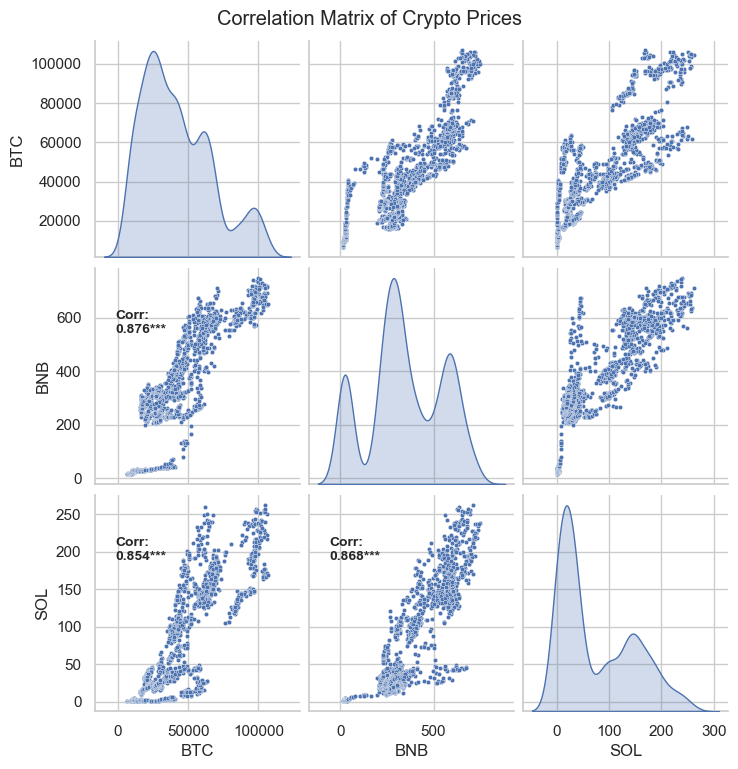

In [179]:
# Load data
df_btc = pd.read_csv('btc-usd-max.csv', index_col='snapped_at', parse_dates=True)
df_eth = pd.read_csv('eth-usd-max.csv', index_col='snapped_at', parse_dates=True)
df_xrp = pd.read_csv('xrp-usd-max.csv', index_col='snapped_at', parse_dates=True)
df_bnb = pd.read_csv('bnb-usd-max.csv', index_col='snapped_at', parse_dates=True)
df_sol = pd.read_csv('sol-usd-max.csv', index_col='snapped_at', parse_dates=True)
df_doge = pd.read_csv('doge-usd-max.csv', index_col='snapped_at', parse_dates=True)
df_pepe = pd.read_csv('pepe-usd-max.csv', index_col='snapped_at', parse_dates=True)
df_dot = pd.read_csv('dot-usd-max.csv', index_col='snapped_at', parse_dates=True)
df_sui = pd.read_csv('sui-usd-max.csv', index_col='snapped_at', parse_dates=True)
df_ada = pd.read_csv('ada-usd-max.csv', index_col='snapped_at', parse_dates=True)
df_shib = pd.read_csv('shib-usd-max.csv',index_col='snapped_at', parse_dates=True)
# Gabungkan harga menjadi satu DataFrame
df = pd.DataFrame({
    'BTC': df_btc['price'],
    #'ETH': df_eth['price'], #omitted
    #'XRP': df_xrp['price'],#omitted
    'BNB': df_bnb['price'],
    'SOL': df_sol['price'],
    #'DOGE': df_doge['price'],#omitted
    #'PEPE': df_pepe['price'],#omitted
    #'DOT':df_dot['price'],  #omitted
    #'SUI':df_sui['price'],#omitted
    #'ADA':df_ada['price'],#omitted
    #'SHIB':df_shib['price']#omitted
})

# Drop baris yang memiliki missing value
df.dropna(inplace=True)

# Custom pairplot with correlation
def corrfunc(x, y, **kws):
    r, p = pearsonr(x, y)
    stars = ''
    if p <= 0.001:
        stars = '***'
    elif p <= 0.01:
        stars = '**'
    elif p <= 0.05:
        stars = '*'
    ax = plt.gca()
    ax.annotate(f'Corr:\n{r:.3f}{stars}', xy=(.1, .7), xycoords=ax.transAxes, fontsize=10, weight='bold')

# Plot
sns.set(style='whitegrid')
g = sns.pairplot(df, kind='scatter', diag_kind='kde', plot_kws={'s': 10})
g.map_lower(corrfunc)
plt.suptitle('Correlation Matrix of Crypto Prices', y=1.02)
plt.show()

We only took some of most correlated coin with bitcoin, and omitted the one with correlation less than absolute value around 0.8 for exogenous 

In [186]:
# Create a new DataFrame with only the most correlated assets
df_major = pd.DataFrame({
    'BTC': df_btc['price'],
    'BNB': df_bnb['price'],
    'SOL': df_sol['price']
})

# Drop rows with missing values to ensure clean alignment
df_major.dropna(inplace=True)
df_major

,BTC,BNB,SOL
snapped_at,,,
2020-04-11 00:00:00+00:00,6864.694257,13.718826,0.957606
2020-04-12 00:00:00+00:00,6878.781213,13.826759,0.784711
2020-04-13 00:00:00+00:00,6913.158787,14.265117,0.875994
2020-04-14 00:00:00+00:00,6857.538538,15.045573,0.786712
2020-04-15 00:00:00+00:00,6860.178536,15.582721,0.666673
...,...,...,...
2025-05-17 00:00:00+00:00,103556.034940,647.341202,167.768124
2025-05-18 00:00:00+00:00,103212.364839,639.597977,165.939417
2025-05-19 00:00:00+00:00,106030.637683,649.380669,171.540675


In [188]:
df_major = df_major.asfreq('d') #daily data
df_major.ffill(inplace=True) #fill forward missing value

In [190]:
print(df_major.isnull().sum()) #check for missing values

BTC    0
BNB    0
SOL    0
dtype: int64


# Creating Returns

In [195]:
df_major['ret_btc'] = df_major.BTC.pct_change(1).mul(100)
df_major['ret_bnb'] = df_major.BNB.pct_change(1).mul(100)
df_major['ret_sol'] = df_major.SOL.pct_change(1).mul(100)

In [197]:
df_major['norm_ret_shib'] = df_major.ret_btc.div(df_major.ret_btc[1])*100
df_major['norm_ret_ada'] = df_major.ret_bnb.div(df_major.ret_bnb[1])*100
df_major['norm_ret_sui'] = df_major.ret_sol.div(df_major.ret_sol[1])*100

# Splitting the Data

In [200]:
size = int(len(df_major)*0.8) #80/20
df, df_test = df_major.iloc[:size], df_major.iloc[size:]

# Autoregressive Model 

In [204]:
model_ar = ARIMA(df.BTC, order = (1,0,0))
results_ar = model_ar.fit()

In [214]:
# create variables that will help us change the periods easily instead of typing them up every time
start_date = "2024-05-12 00:00:00+00:00"
end_date = "2025-05-21 00:00:00+00:00"

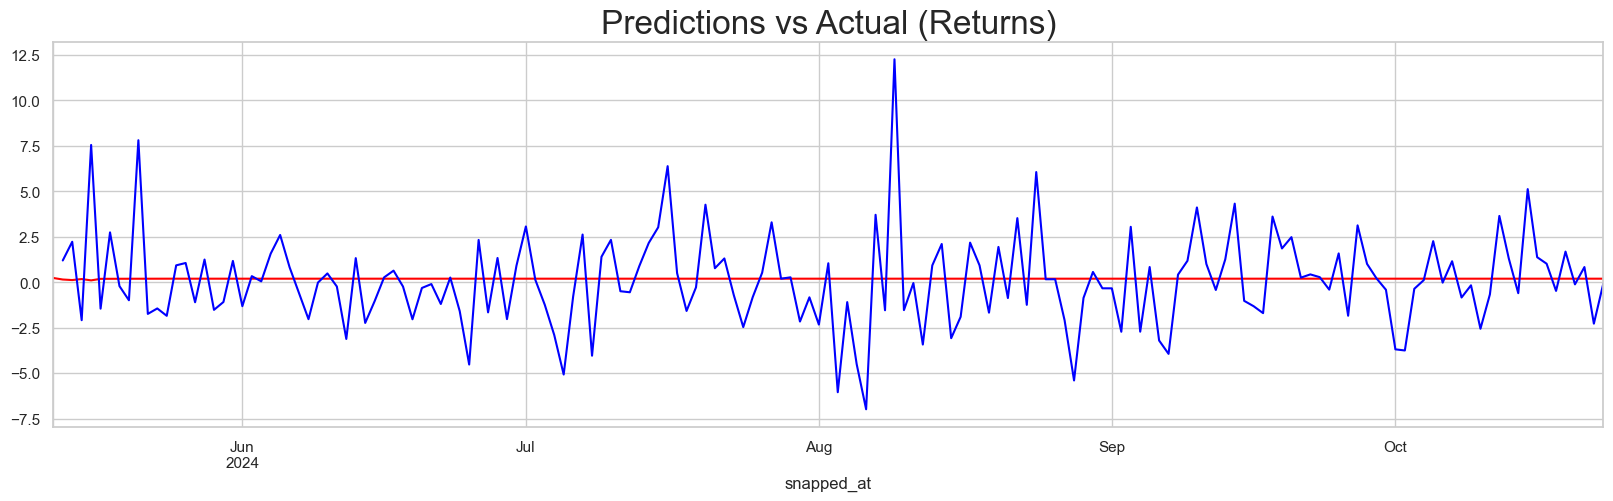

In [222]:
end_date = "2024-10-23 00:00:00+00:00"

model_ret_ar = ARIMA(df.ret_btc[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_btc[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [224]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ret_btc   No. Observations:                 1492
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -3883.744
Date:                Sat, 31 May 2025   AIC                           7781.487
Time:                        11:35:28   BIC                           7818.643
Sample:                    04-12-2020   HQIC                          7795.333
                         - 05-12-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1996      0.091      2.193      0.028       0.021       0.378
ar.L1         -0.0289      0.022     -1.324      0.185      -0.072       0.014
ar.L2          0.0133      0.024      0.552      0.581      -0.034       0.061
ar.L3          0.0230      0.025      0.933      0.351      -0.025       0.071
ar.L4          0.0204      0.022      0.941      0.347      -0.022       0.063
ar.L5          0.0220      0.024      0.929      0.353      -0.024       0.068
sigma2        10.6782      0.241     44.256      0.000      10.205      11.151
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               711.22
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This result expected from AR model since it simple model.

# Moving Average

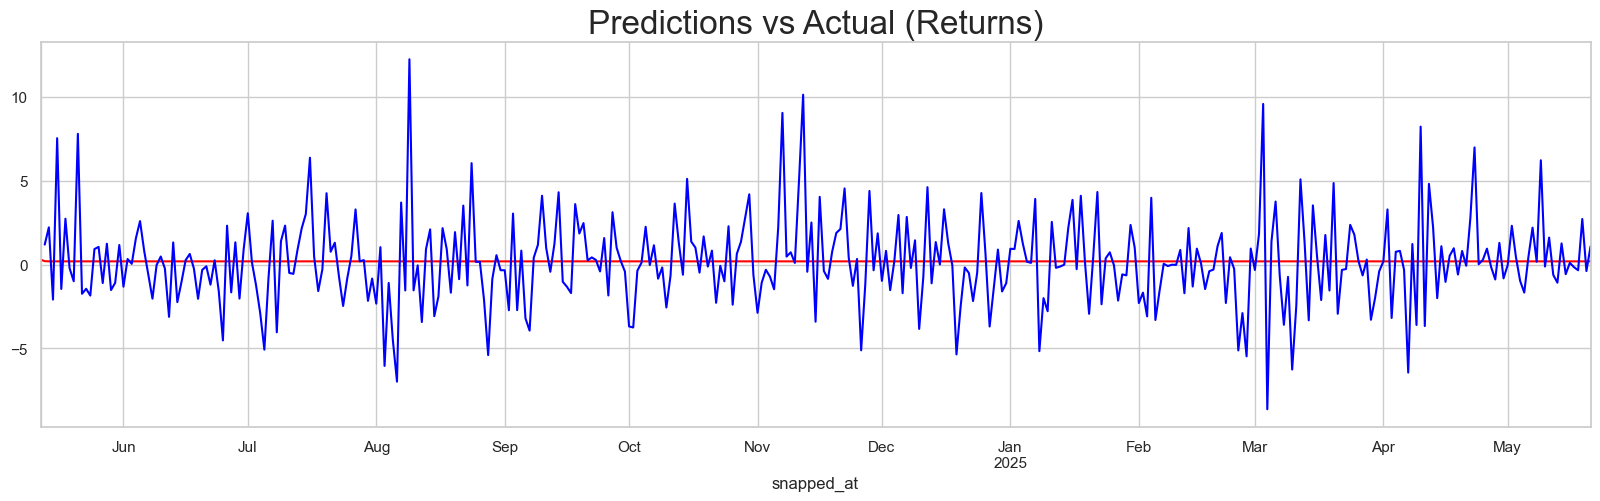

In [338]:
end_date = "2025-05-21 00:00:00+00:00"

model_ret_ma = ARIMA(df.ret_btc[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_btc[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

The same thing apply with moving average model since it's simple model.

# Arma

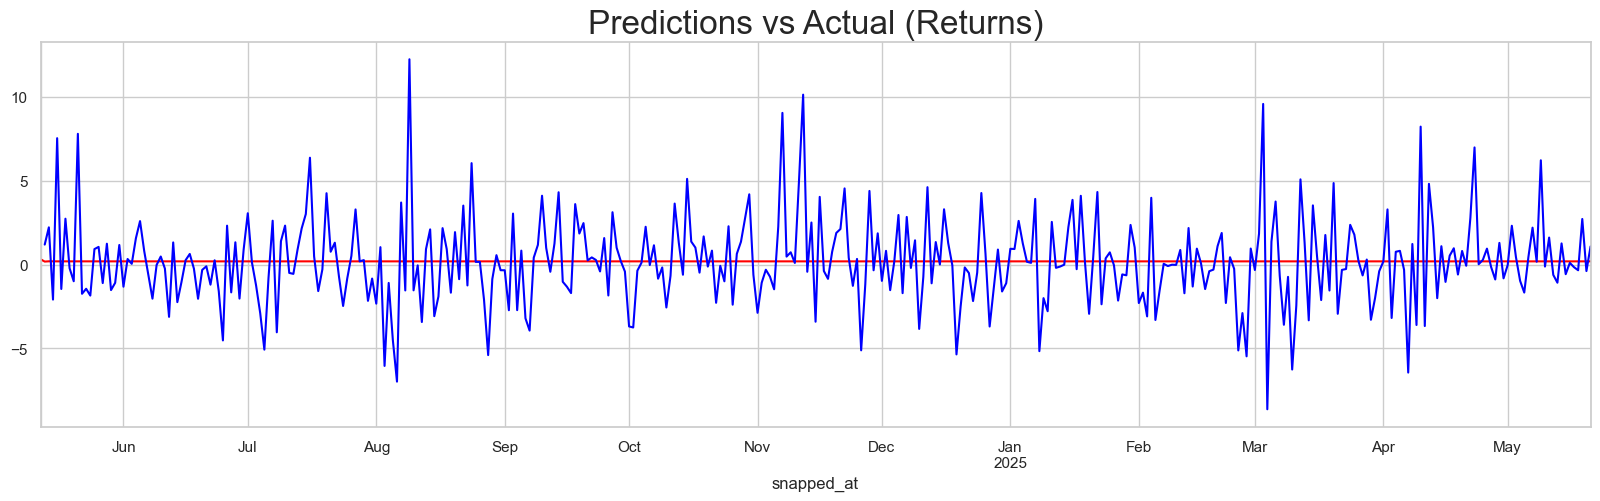

In [341]:
model_ret_arma = ARIMA(df.ret_btc[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_btc[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

Even ARMA which combine AR with MA doesnt seem any different, just the first line seem a bit bent.

# ARMAX

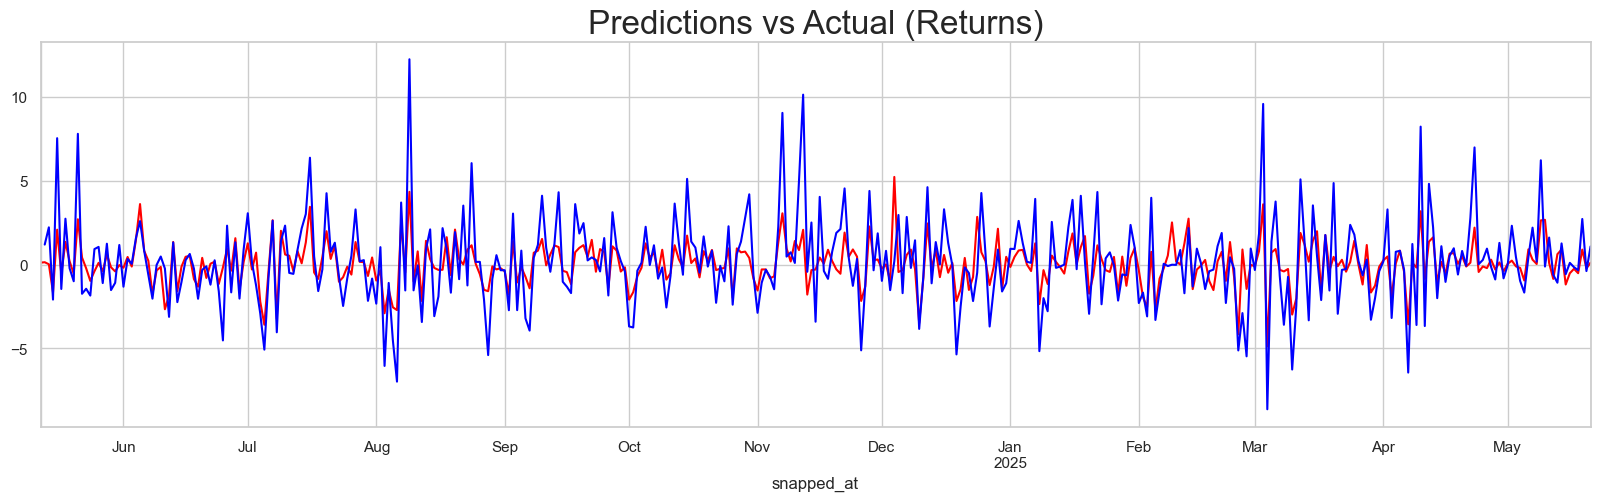

In [344]:
model_ret_armax = ARIMA(df.ret_btc[1:], exog = df[["ret_bnb","ret_sol"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_bnb","ret_sol"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_btc[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

Something interesting when we add exog variable which correlated with btc price, the predict seems good at predicting the return, eventhough some outlier to the return doesnt seems to capture in model.

# SARMA

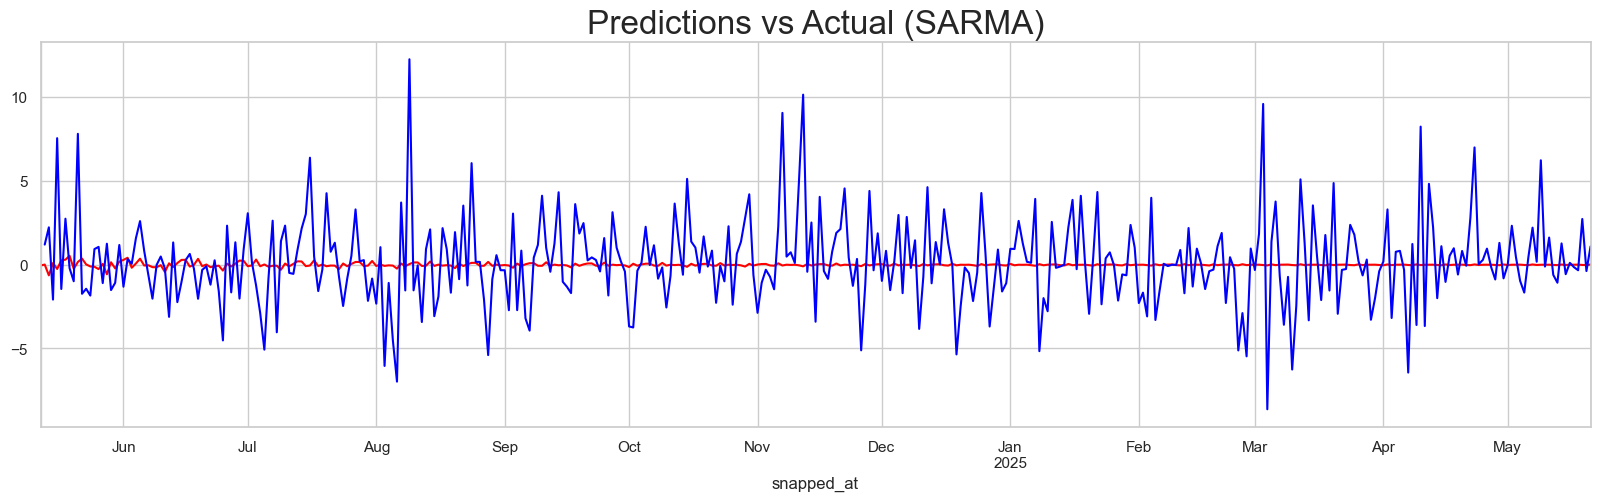

In [347]:
model_ret_sarma = SARIMAX(df.ret_btc[1:], order = (3,0,4), seasonal_order = (3,0,2,7))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_btc[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

When we add seasonality into the model, it's doesnt seems too good at predicting, on the initial return it looks wavy but becomes more stable as it gets longer.

# SARIMAX

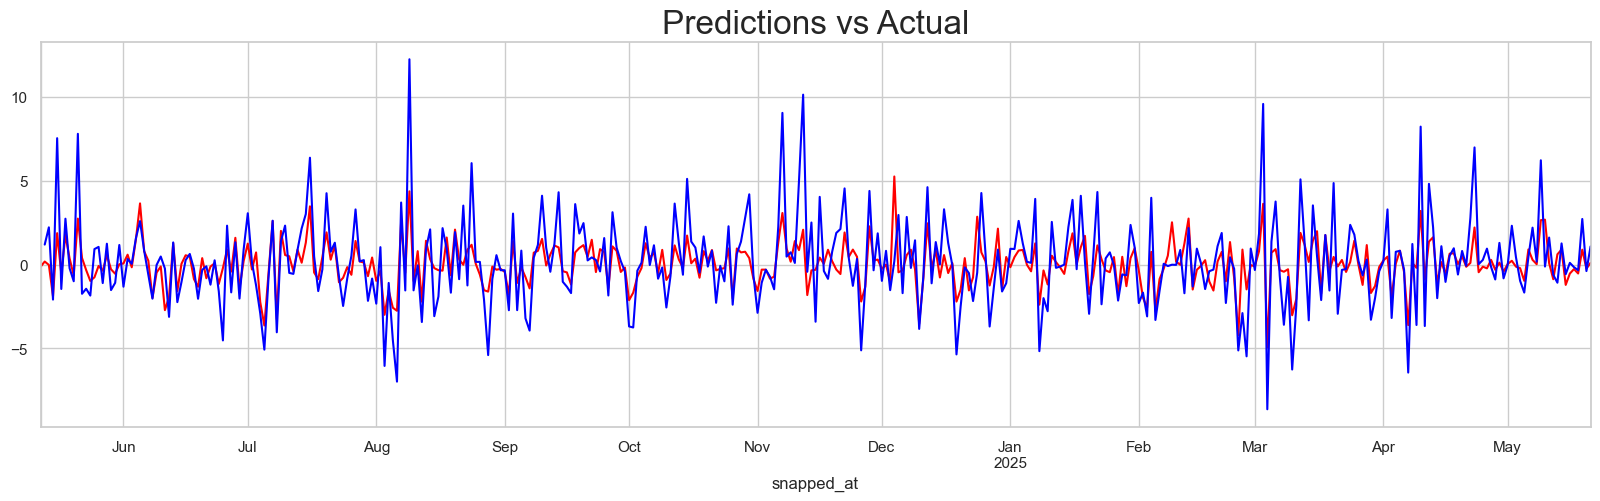

In [349]:
model_ret_sarimax = SARIMAX(df.ret_btc[1:], exog = df[["ret_bnb","ret_sol"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,7))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_bnb","ret_sol"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_btc[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

When we add exog, seasonality, AR, and MA into calculation the prediction become batter, we also notice that exog variable have a lot of impact in the model predict result.

# Auto ARIMA

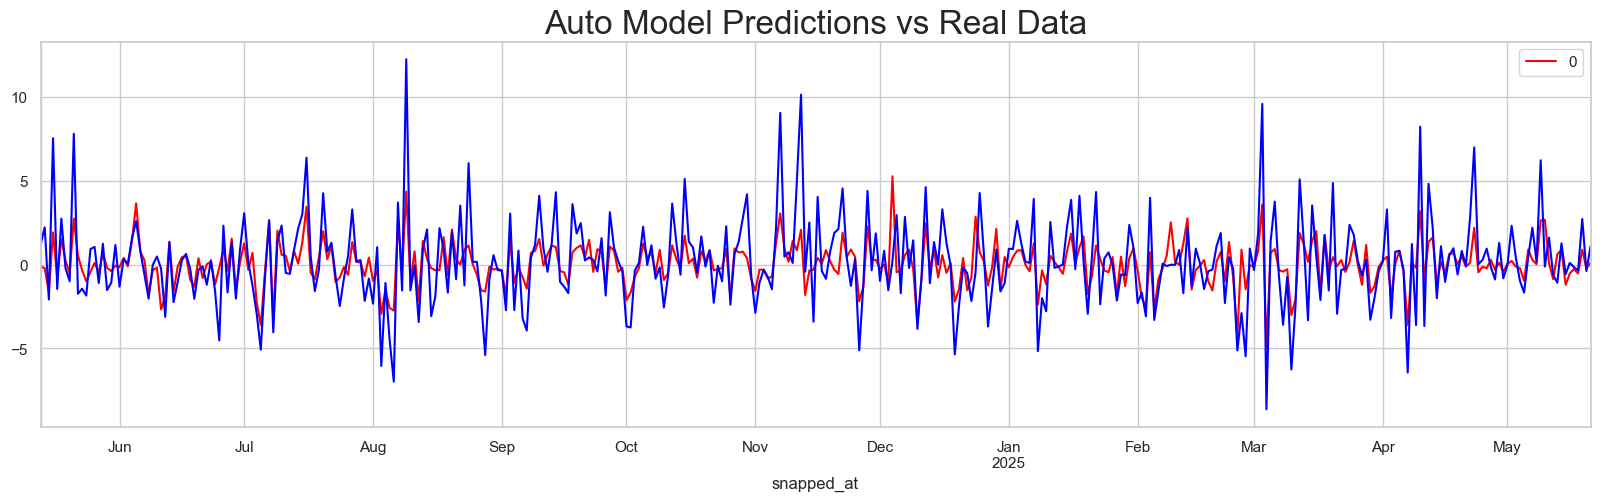

In [351]:
model_auto = auto_arima(df.ret_btc[1:], X = df[["ret_bnb","ret_sol"]][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            X = df_test[["ret_bnb","ret_sol"]][start_date:end_date]),
                            index = df_test[start_date:end_date].index)
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_btc[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

This also applies to auto_arima. However, a simpler model is not necessarily bad — the results must always be evaluated.

# Comparing All the Models (Returns)

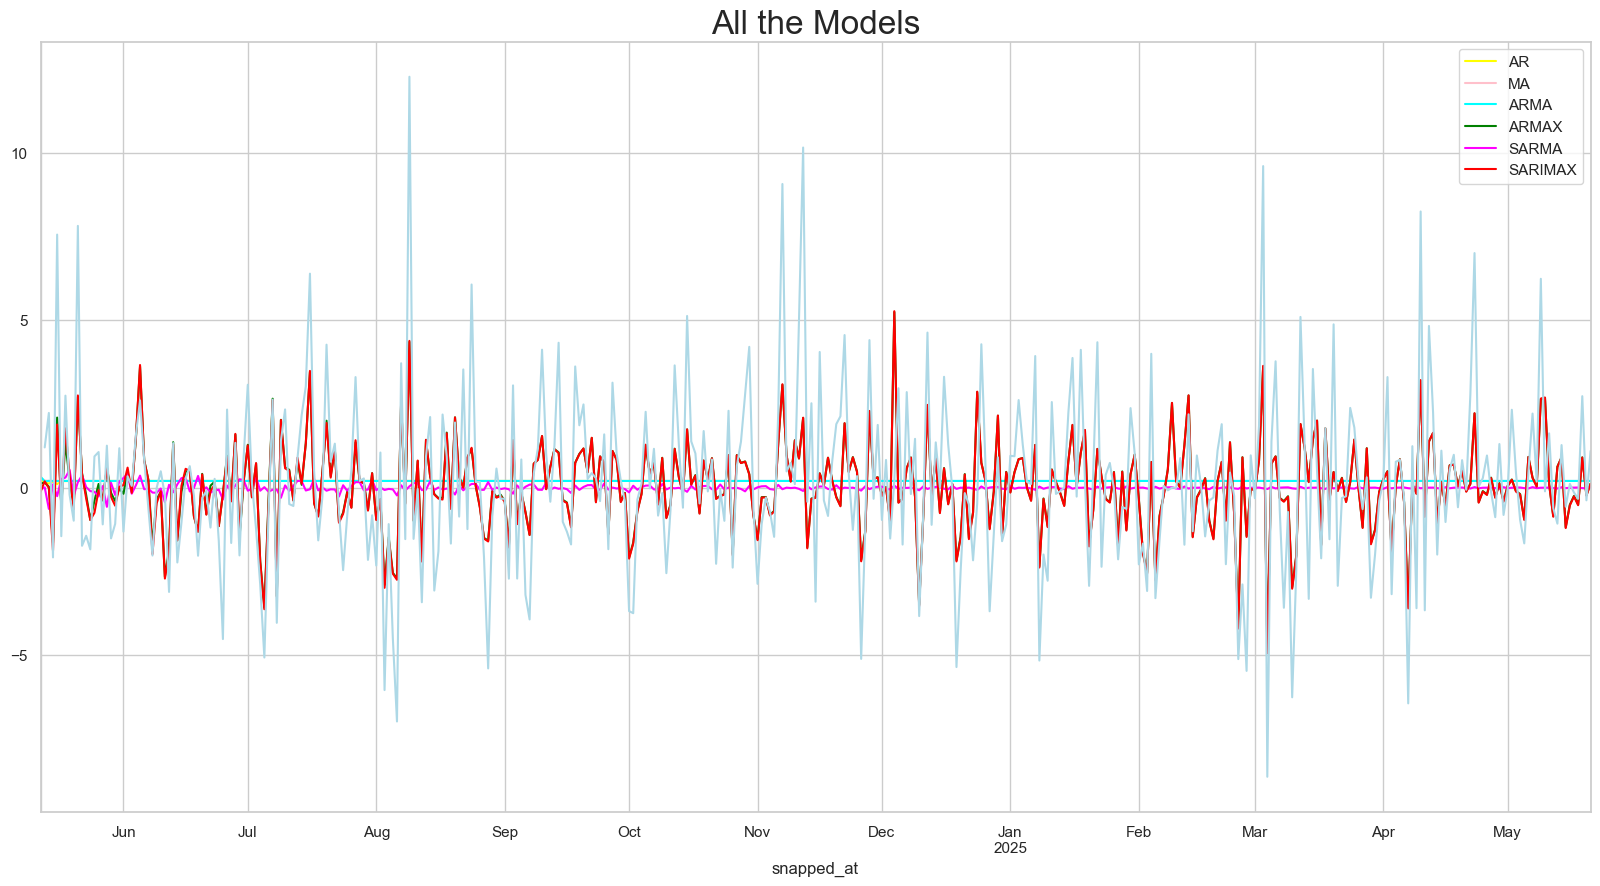

In [357]:
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_btc[start_date:end_date].plot(color = "lightblue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

As we can see SARIMAX seems to be the best model in predicting bitcoin price.

# Forecasting Volatility

In [363]:
mod_garch = arch_model(df_major.ret_btc[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     62,   Neg. LLF: 3822.471804096207
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3822.4718040959997
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10


In [365]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

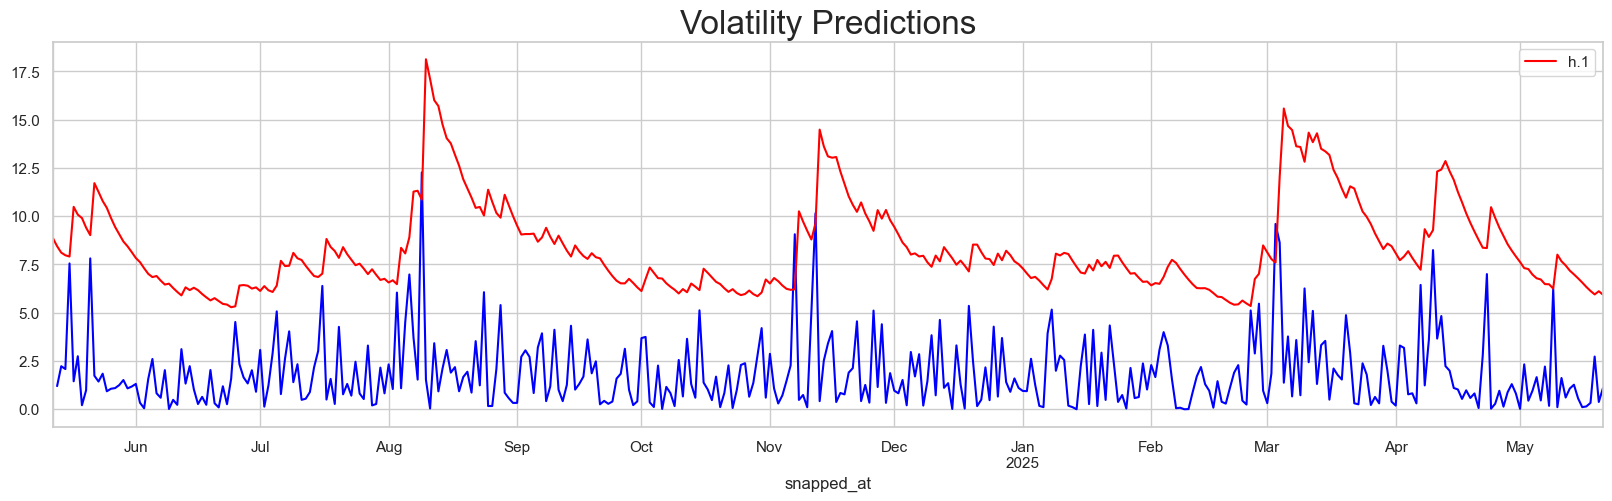

In [371]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_btc.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In addition to predicting returns, we can also forecast volatility in Bitcoin prices using a simple GARCH model. As shown, the model effectively captures periods of heightened volatility, demonstrating its usefulness in modeling risk dynamics.